In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Data

### Constants

In [2]:
N = 20
FACTOR = 1 / torch.sqrt(torch.tensor(N))
K = 11

In [3]:
NUM_SAMPLES = 2000

In [4]:
def generate_data_1() -> torch.Tensor:
    """
    Returns one sample of data from distribution D_A^(1)
    """
    return torch.sign((torch.rand(N) * 2. - 1.)) * FACTOR

In [5]:
def generate_data_2(imp_cols: torch.Tensor) -> torch.Tensor:
    """
    Returns one sample of data from distribution D_A^(2)

    Arg:
        imp_cols (torch.Tensor): Tensor of columns which are significant in the distribution
    """
    x = torch.sign((torch.rand(N) * 2. - 1.)) * FACTOR
    sign = torch.sign((torch.rand(1) * 2. - 1.))
    for col in imp_cols:
        x[col] = sign * FACTOR
    return x

In [6]:
from numpy.random import choice

A = choice(range(N), K, False)
A

array([ 2,  0, 15,  8, 16, 18, 14,  5,  9,  4, 12])

In [7]:
def get_y_from_data(x: torch.Tensor, imp_cols: torch.Tensor) -> torch.Tensor:
    """
    Returns label y (0 or 1) given a single data point x

    Args:
        x (torch.Tensor): Data tensor
        imp_cols (torch.Tensor): Significant columns from the data
    """
    y = torch.tensor(1.)
    for col in imp_cols:
        y *= torch.sign(x[col])
    if y <= 0:
        y = torch.tensor(0.)
    return y

### Generating data

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
function_choices = torch.round(torch.rand(NUM_SAMPLES))

In [10]:
X = torch.cat([generate_data_1().reshape(1, -1) if function_choices[i] == 0 else generate_data_2(A).reshape(1, -1) for i in range(NUM_SAMPLES)])
X.shape

torch.Size([2000, 20])

In [11]:
Y = torch.cat([get_y_from_data(x, A).reshape(1, -1) for x in X])
Y.shape

torch.Size([2000, 1])

In [12]:
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=0.25)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([1200, 20]),
 torch.Size([1200, 1]),
 torch.Size([400, 20]),
 torch.Size([400, 1]),
 torch.Size([400, 20]),
 torch.Size([400, 1]))

In [13]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True), make_dataloader(X_val, Y_val, batch_size=32, shuffle=True)

## Models

### Neural network

In [14]:
device = 'cpu'

In [15]:
from scripts.models import SimpleNN
from scripts.metrics import BinaryAccuracy
from scripts.train import train_model
from scripts.utils import EarlyStopping

In [16]:
depths = [1, 2, 3, 4, 5]
widths = [16, 32, 64]
weight_decays = torch.logspace(-3, 3, 7)
etas = [1e-4, 1e-3, 1e-2]


In [17]:
best_score = 0.0
best_depth = None
best_width = None
best_weight_decay = None
best_eta = None

In [18]:
total_count = len(depths) * len(widths) * len(weight_decays) * len(etas)
count = 0
EPOCHS = 50

print(f'Cross-validating across {total_count} models.\n')

for depth in depths:
    for width in widths:
        for weight_decay in weight_decays:
            for eta in etas:
                count += 1
                model = SimpleNN(input_size=N, hidden_layers=depth, hidden_units=width).to(device)
                loss_fn = torch.nn.BCELoss()
                optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, weight_decay=weight_decay)
                metric = BinaryAccuracy()

                history = train_model(
                    model=model,
                    train_dataloader=train_dataloader,
                    val_dataloader=val_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    metric=metric,
                    epochs=50,
                    verbose=0,
                    device=device
                )
                curr_score = history['val_score'][-1]

                print(f'[{count}/{total_count}] depth={depth}, width={width}, lambda={weight_decay:.5f}, eta={eta} ===> validation score={curr_score:.6f}')
                if curr_score > best_score:
                    best_score = curr_score
                    best_depth = depth
                    best_width = width
                    best_weight_decay = weight_decay
                    best_eta = eta

print(f'Validation complete. Best validation score after {EPOCHS} epochs = {best_score:.6f}')
print(f'Best configuration: depth={best_depth}, width={best_width}, lambda={best_weight_decay:.5f}, eta={best_eta}')

Cross-validating across 315 models.

[1/315] depth=1, width=16, lambda=0.00100, eta=0.0001 ===> validation score=0.718750
[2/315] depth=1, width=16, lambda=0.00100, eta=0.001 ===> validation score=0.757212
[3/315] depth=1, width=16, lambda=0.00100, eta=0.01 ===> validation score=0.742788
[4/315] depth=1, width=16, lambda=0.01000, eta=0.0001 ===> validation score=0.706731
[5/315] depth=1, width=16, lambda=0.01000, eta=0.001 ===> validation score=0.735577
[6/315] depth=1, width=16, lambda=0.01000, eta=0.01 ===> validation score=0.747596
[7/315] depth=1, width=16, lambda=0.10000, eta=0.0001 ===> validation score=0.480769
[8/315] depth=1, width=16, lambda=0.10000, eta=0.001 ===> validation score=0.478365
[9/315] depth=1, width=16, lambda=0.10000, eta=0.01 ===> validation score=0.483173
[10/315] depth=1, width=16, lambda=1.00000, eta=0.0001 ===> validation score=0.516827
[11/315] depth=1, width=16, lambda=1.00000, eta=0.001 ===> validation score=0.471154
[12/315] depth=1, width=16, lambda=1

In [19]:
best_model_nn = SimpleNN(input_size=N, hidden_layers=best_depth, hidden_units=best_width).to(device)

In [20]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_nn.parameters(), lr=best_eta, weight_decay=best_weight_decay)
metric = BinaryAccuracy()
early_stopper = EarlyStopping(patience=20, min_delta=1e-4)

In [21]:
history = train_model(
    model=best_model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stopper,
    device=device
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.502756, Train score: 0.750000, Val loss: 0.460997, Val score: 0.762019
Epoch: 2 => Train loss: 0.441571, Train score: 0.767270, Val loss: 0.452185, Val score: 0.759615
Epoch: 3 => Train loss: 0.418949, Train score: 0.778783, Val loss: 0.433486, Val score: 0.752404
Epoch: 4 => Train loss: 0.400023, Train score: 0.774671, Val loss: 0.448371, Val score: 0.766827
Epoch: 5 => Train loss: 0.408094, Train score: 0.769737, Val loss: 0.416683, Val score: 0.771635
Epoch: 6 => Train loss: 0.397973, Train score: 0.765625, Val loss: 0.415941, Val score: 0.754808
Epoch: 7 => Train loss: 0.395387, Train score: 0.775493, Val loss: 0.422666, Val score: 0.757212
Epoch: 8 => Train loss: 0.378651, Train score: 0.777961, Val loss: 0.403255, Val score: 0.762019
Epoch: 9 => Train loss: 0.380627, Train score: 0.775493, Val loss: 0.416055, Val score: 0.764423
Epoch: 10 => Train loss: 0.378406, Train score: 0.782072, Val loss: 0.39

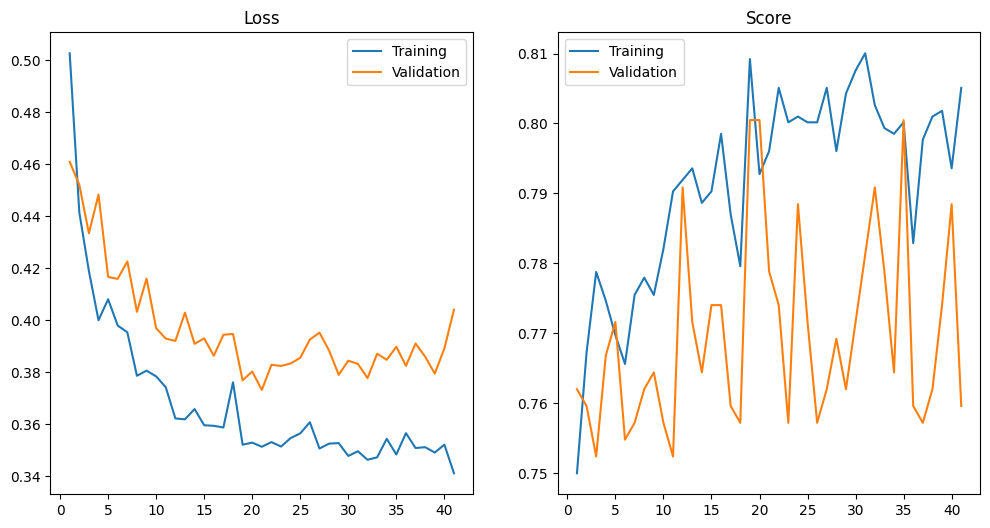

In [22]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [23]:
from scripts.test import predict

preds_train, preds_val = predict(best_model_nn, X_train, device), predict(best_model_nn, X_val, device)
score_train, score_val = metric(preds_train, Y_train), metric(preds_val, Y_val)
score_train, score_val

(tensor(0.7792), tensor(0.7575))

In [32]:
preds_test = predict(best_model_nn, X_test, device)
score_test = metric(preds_test, Y_test)
score_test

tensor(0.7725)

### SVM

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from scripts.ntk import NTK

In [25]:
ntk = NTK(best_model_nn).get_ntk

In [26]:
model_base_ntk = SVC(kernel=ntk)
params_ntk = {
    'C': np.logspace(-3, 3, 7)
}

gammas = np.logspace(-5, 5, 11, base=2).tolist()
gammas.append('scale')
gammas.append('auto')
model_base_rbf = SVC()
params_rbf = {
    'C': np.logspace(-3, 3, 7),
    'gamma': gammas
}

scorer = make_scorer(accuracy_score)

In [27]:
model_cv_ntk = GridSearchCV(estimator=model_base_ntk, param_grid=params_ntk, scoring=scorer, n_jobs=5, refit=False, cv=5, verbose=3)
model_cv_ntk.fit(X_train, Y_train.squeeze())
best_params_ntk = model_cv_ntk.best_params_
best_score_ntk = max(model_cv_ntk.cv_results_['mean_test_score'])
best_params_ntk

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 2/5] END ...........................C=0.001;, score=0.504 total time=   2.9s
[CV 3/5] END ...........................C=0.001;, score=0.504 total time=   2.8s
[CV 4/5] END ...........................C=0.001;, score=0.504 total time=   2.9s
[CV 5/5] END ...........................C=0.001;, score=0.500 total time=   3.2s
[CV 1/5] END ...........................C=0.001;, score=0.504 total time=   3.2s
[CV 1/5] END ............................C=0.01;, score=0.583 total time=   2.4s
[CV 2/5] END ............................C=0.01;, score=0.621 total time=   2.3s
[CV 3/5] END ............................C=0.01;, score=0.575 total time=   2.4s
[CV 4/5] END ............................C=0.01;, score=0.604 total time=   2.3s
[CV 5/5] END ............................C=0.01;, score=0.596 total time=   2.5s
[CV 1/5] END .............................C=0.1;, score=0.796 total time=   2.3s
[CV 2/5] END .............................C=0.1;,

{'C': 1000.0}

In [28]:
model_cv_rbf = GridSearchCV(estimator=model_base_rbf, param_grid=params_rbf, scoring=scorer, n_jobs=5, refit=False, cv=5, verbose=3)
model_cv_rbf.fit(X_train, Y_train.squeeze())
best_params_rbf = model_cv_rbf.best_params_
best_score_rbf = max(model_cv_rbf.cv_results_['mean_test_score'])
best_params_rbf

Fitting 5 folds for each of 91 candidates, totalling 455 fits
[CV 4/5] END ............C=0.001, gamma=0.03125;, score=0.504 total time=   0.0s
[CV 3/5] END ............C=0.001, gamma=0.03125;, score=0.504 total time=   0.1s
[CV 2/5] END ............C=0.001, gamma=0.03125;, score=0.504 total time=   0.1s
[CV 5/5] END ............C=0.001, gamma=0.03125;, score=0.500 total time=   0.1s
[CV 1/5] END ............C=0.001, gamma=0.03125;, score=0.504 total time=   0.1s
[CV 1/5] END .............C=0.001, gamma=0.0625;, score=0.504 total time=   0.1s
[CV 2/5] END .............C=0.001, gamma=0.0625;, score=0.504 total time=   0.1s
[CV 3/5] END .............C=0.001, gamma=0.0625;, score=0.504 total time=   0.1s
[CV 4/5] END .............C=0.001, gamma=0.0625;, score=0.504 total time=   0.1s
[CV 5/5] END .............C=0.001, gamma=0.0625;, score=0.500 total time=   0.1s
[CV 1/5] END ..............C=0.001, gamma=0.125;, score=0.504 total time=   0.1s
[CV 3/5] END ..............C=0.001, gamma=0.125

{'C': 0.01, 'gamma': 0.25}

In [29]:
if best_score_ntk > best_score_rbf:
    best_model_km = SVC(C=best_params_ntk['C'], kernel=ntk, tol=1e-4)
else:
    best_model_km = SVC(C=best_params_rbf['C'], gamma=best_params_rbf['gamma'], tol=1e-4)

In [30]:
best_model_km.fit(X_train, Y_train.squeeze())

SVC(C=1000.0,
    kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7f5e9a04a380>>,
    tol=0.0001)

In [31]:
preds_train, preds_val = best_model_km.predict(X_train), best_model_km.predict(X_val)
score_train, score_val = accuracy_score(Y_train, preds_train), accuracy_score(Y_val, preds_val)
score_train, score_val

(0.9166666666666666, 0.7825)

In [33]:
preds_test = best_model_km.predict(X_test)
score_test = accuracy_score(Y_test, preds_test)
score_test

0.7925

In [ ]:
# Try with MNIST data next, as in the paper